# Hydrography of the DCA: timeseries of depth profiles

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import gsw
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import datetime
from datetime import timedelta
from scipy import interpolate
import seaborn as sns
sns.set_style('dark')
from info import datadir, figdir

## Loading data

In [2]:
data = sio.loadmat(datadir+'timedepth_DCA.mat')

time = data['time'][0]
t0 = datetime.datetime(1950,1,1,0,0) # origin of time = 1 January 1950, 00:00:00 UTC
dates = np.array([t0 + datetime.timedelta(hours=i) for i in time])
depth = data['depth'][0]
p = data['p'][0]

SA = data['SA']
CT = data['CT']
sigma0 = data['sigma0']
mld_mean = data['mld_mean'][0]
mld_max = data['mld_max'][0]

In [3]:
maxdepth = np.max(mld_max)
print('Maximum mixed layer depth: %.2f'%maxdepth+' m')

Maximum mixed layer depth: 2090.52 m


## Preparing data

In [4]:
def regrid_vertical(data, time, vert):
    """
    vert: either depth or pressure
    """
    f = interpolate.interp2d(time,vert,np.transpose(data), kind='linear')
    xi = time
    yi = np.linspace(vert[0],vert[-1],len(vert))
    Time,Vert = np.meshgrid(xi,yi)
    data_interp = f(xi,yi)
    return Time,Vert,data_interp

In [5]:
# Regrid SA, CT, sigma0 to regular depth grid
# First, throw away last 3 depth points that have no data

depths = depth[0:-3]
SA_valid = SA[:,0:-3]
CT_valid = CT[:,0:-3]
sigma0_valid = sigma0[:,0:-3]

_,_,SA_regrid = regrid_vertical(SA_valid, time, depths)
_,_,CT_regrid = regrid_vertical(CT_valid, time, depths)
Time,Depth,sigma0_regrid = regrid_vertical(sigma0_valid, time, depths)

## Plotting

In [6]:
def plotTimeDepth(ax,Time,Vert,data,levels,cmap,verttype,maxv,label,title,inv_cbar=False):
    plot = ax.contourf(Time,Vert,data,levels=levels,extend='both',cmap=cmap)
    cbar = plt.colorbar(plot, ax=ax)
    if verttype=='depth':
        ax.set_ylabel('Depth (m)', fontsize=15)
    else:
        ax.set_ylabel('Pressure (dbar)', fontsize=15)
    ax.set_ylim(0,maxv)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks(time[0::24])
    ax.set_xticklabels([dates[i].year for i in np.arange(0,len(time[0::24])*24,24)])
    ax.set_title(title,fontsize=17)
    cbar.ax.set_ylabel(label,fontsize=14)
    cbar.ax.tick_params(axis='y', which='both', labelsize=14)
    cbar.ax.get_yaxis().labelpad = 25
    if inv_cbar:
        cbar.ax.invert_yaxis()

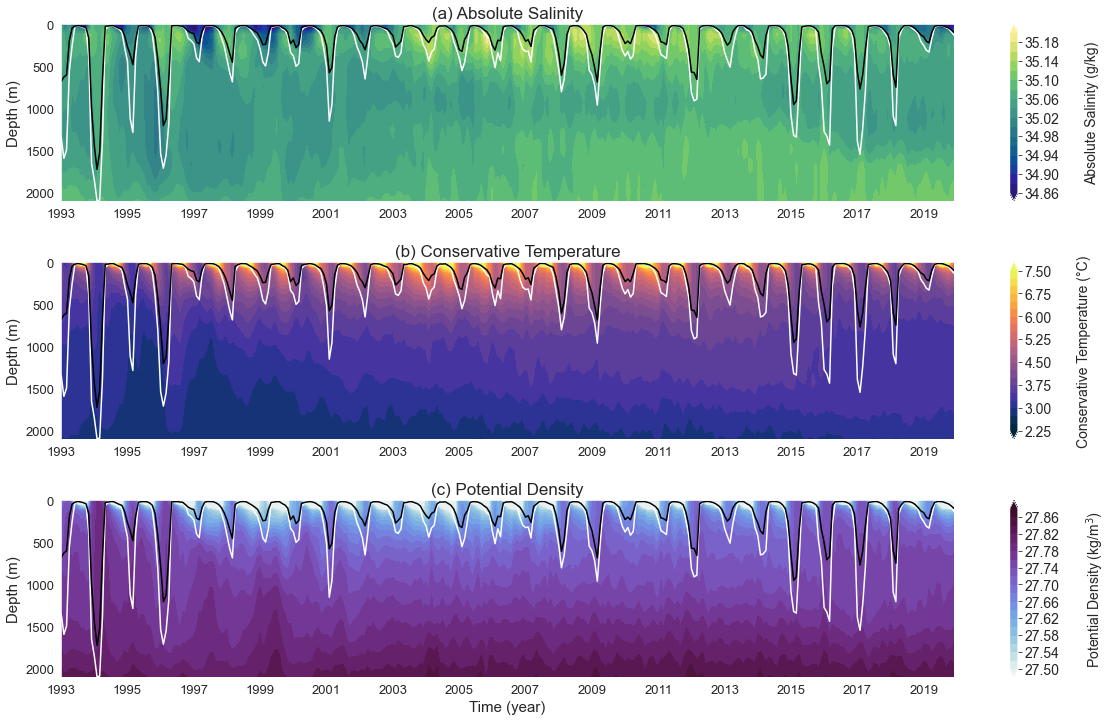

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,12))

S_levels = np.arange(34.86,35.2,0.02)
plotTimeDepth(ax1,Time,Depth,SA_regrid,S_levels,'cmo.haline','depth',maxdepth,
              'Absolute Salinity (g/kg)','(a) Absolute Salinity', inv_cbar = False)
ax1.plot(time,mld_max,color='white')
ax1.plot(time,mld_mean,color='black')

T_levels = np.arange(2.25,7.55,0.25)
plotTimeDepth(ax2,Time,Depth,CT_regrid,T_levels,'cmo.thermal','depth',maxdepth,
              'Conservative Temperature ('+'\u00B0'+'C)','(b) Conservative Temperature')
ax2.plot(time,mld_max,color='white')
ax2.plot(time,mld_mean,color='black')

sigma_levels = np.arange(27.5,27.9,0.02)
plotTimeDepth(ax3,Time,Depth,sigma0_regrid,sigma_levels,'cmo.dense','depth',maxdepth,
              'Potential Density (kg/m$^3$)','(c) Potential Density', inv_cbar = False)
ax3.plot(time,mld_max,color='white')
ax3.plot(time,mld_mean,color='black')
ax3.set_xlabel('Time (year)', fontsize=15)

fig.subplots_adjust(hspace=0.35)
plt.savefig(figdir+'timedepth_full.png',bbox_inches='tight')
plt.show()